## Spectral integrals in Underworld2

Underworld2 currently supports area (volume) and surface integrals. But there is no inherent capacity to integrate a 2D function independently along separate axes. However, we can generate a Fourier /(wavenumber) representation of such an integral. Consider a 2D scalar field $F(x,y)$, where we want to determine the function representing the the integrated value over the y-axis: 


\begin{equation}f(x) = \int F(x,y) \mathop{dy}  = A_0 +  \sum_{k=1}^N a_k \cdot cos(kx)  +  b_k \cdot sin(kx)   \end{equation}


\begin{equation} A_0 = \int_\Omega F(x,y) \mathop{dx}\mathop{dy}  \end{equation} 


\begin{equation} a_k = \int_\Omega  cos(kx)\cdot F(x,y)  \mathop{dx}\mathop{dy}  \end{equation} 

\begin{equation} b_k = \int_\Omega  sin(kx)\cdot  F(x,y)\mathop{dx}\mathop{dy}  \end{equation} 


The Underworld2 `function` module provides all the necessary apparatus us to compute these integrals, and therfore to 
generate the Fourier coefficents. Some advantages of this proceedure: 

* it can be performed in parallel, and hence during Underworld simulations, rather than as a post-processign step
* the proceedure utilises (numerical) Fourier integrals (rather than FFT), meaning that the proceedure can be applied to deformed meshes. 

On the other hand, these spectral integrals are quite computationally expensive (i.e compared using FFTs on similar sized arrays) and are therefore likely to be practical only in 2D. 

A specific application of this proceedure is in spectral domain calculation of gravity anomalies, also known as __upward continuation__. We'll cover some examples of upward continuation in the following notebooks. But first, let's consider a simple function in the unit square with an origin at (0,0):


\begin{equation} F(x,y) = \cos(\pi x) * \cos(\pi y)\end{equation}

\begin{equation}f(x) = \int F(x,y) \mathop{dy}  = \frac{2}{\pi} \sin(\pi x) \end{equation} 

\begin{equation} A_0 = \int_{-0.5}^{0.5} \int_{-0.5}^{0.5} F(x,y) \mathop{dx}\mathop{dy}  = \left(\frac{2}{\pi} \right)^2 \end{equation} 

## Set up Underworld model

In [45]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
from scipy.integrate import simps, trapz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [95]:
# first create a mesh and variable
mesh = uw.mesh.FeMesh_Cartesian(elementType = 'Q1/dQ0', 
                                elementRes=(51,51),
                                minCoord    = (-0.5, -0.5), 
                                maxCoord    = (0.5, 0.5) )




In [96]:
#Set up our example function
xFn = fn.input()[0]
yFn = fn.input()[1]

yCosFn = (fn.math.cos(np.pi*yFn))
xCosFn = (fn.math.cos(np.pi*xFn))

combFn = xCosFn*yCosFn

In [97]:
#plt.plot(xCosFn.evaluate(tWalls))


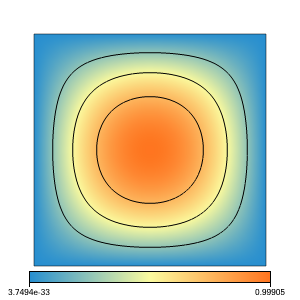

In [98]:
fig = glucifer.Figure(quality=3, figsize=(300,300))
fig.append( glucifer.objects.Surface(mesh,combFn, onMesh=True), colourBar=False )
fig.append( glucifer.objects.Contours(mesh,combFn, colours = 'black',colourBar=False, interval=0.25) )

fig.show()

In [99]:
# create set of wavenumbers / modes

res = mesh.elementRes[0]
width = mesh.maxCoord[0] - mesh.minCoord[0]

n =  11                #number of modes to use ( incl. the zeroth mode )

x = fn.coord()[0]
modes = []
ks_ = []
#start from 1, as the zeroth mode is performed using a regular volume integral)
for i in range(1,n):
    print(i)
    factor = float(i)*2.*np.pi/width
    modes.append(factor*x)
    ks_.append(factor)
sinfns = fn.math.sin(modes)
cosfns = fn.math.cos(modes)

1
2
3
4
5
6
7
8
9
10


In [100]:
sin_coeffs = uw.utils.Integral(combFn*sinfns,mesh)
cos_coeffs = uw.utils.Integral(combFn*cosfns,mesh)
average = uw.utils.Integral(combFn,mesh)


synthFn = (2./width)*fn.math.dot(sin_coeffs.evaluate(),sinfns) + \
          (2./width)*fn.math.dot(cos_coeffs.evaluate(),cosfns) + \
                     average.evaluate()[0]
        
trueFn = (2./np.pi)*xCosFn

In [101]:
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls = mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]

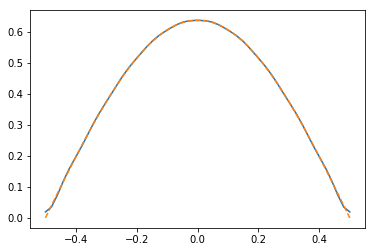

In [102]:
plt.plot(mesh.data[tWalls.data][:,0], synthFn.evaluate(tWalls ))
plt.plot(mesh.data[tWalls.data][:,0], trueFn.evaluate(tWalls ),ls='--' )

In [119]:
sc = sin_coeffs.evaluate()
cc = cos_coeffs.evaluate()


oscill = np.ones(len(cc[:]))
oscill[0::2] *=-1

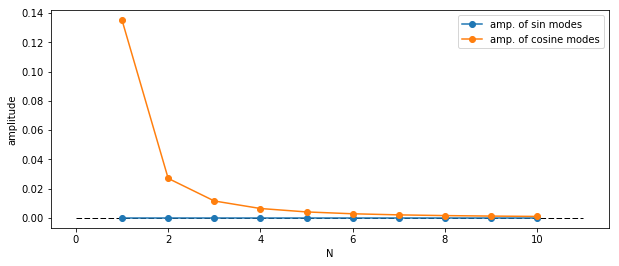

In [125]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np.arange(n-1) + 1, -1.*oscill*sc[:],label = 'amp. of sin modes', marker='o'  )
ax.plot(np.arange(n-1) + 1, -1.*oscill*cc[:], label = 'amp. of cosine modes' , marker='o' )

ax.legend()

ax.hlines(0,0, n, linestyles='--', lw=1. )
#ax.vlines(nk - 1,-0.2*cc[0], cc[0], linestyles='--', lw=1. )

ax.set_xlabel('N')
ax.set_ylabel('amplitude')

## Numpy Version (& mode leakage)

Alhough the analytic function ($f(x)$) contained a single wavenumber, the Underworld intrgral (sprectral intragal) contained finite amplitudes at a series of wavenumbers. This is a case of spectral leakage, a well-known phenemonon caused by samling. We'll now compute the same integral using Numpy's FFT module to demonstrate that the leakage is virtually identical. Because Numpy uses the FFT, we can use all wavenumbers at very little computational cost (but iis restricted to running on a single processor).

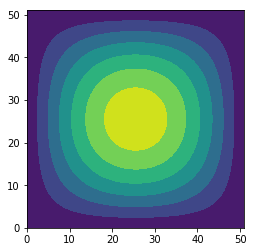

In [111]:
#reshape our function into 2D array for Numby to work with
arrayData = combFn.evaluate(mesh).reshape(mesh.elementRes[0] + 1, mesh.elementRes[1] + 1)

fig, ax = plt.subplots()
ax.contourf(arrayData)
ax.set_aspect('equal')

In [114]:
#compute the numpy FFT 

arrayFFT = np.fft.rfft(arrayData) #create the row-wise FFT 

depths = mesh.data[lWalls.data][:,1]
fftSum = simps(arrayFFT, x = depths, axis=0) #integrate in y using Simsons' Rule

#do the inverse transform (Fourier synthesis 
arraySum = np.fft.irfft(fftSum)


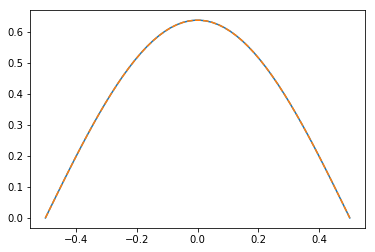

In [115]:
arrayXs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0],  arraySum.shape[0])
plt.plot(arrayXs , arraySum)
plt.plot(mesh.data[tWalls.data][:,0], trueFn.evaluate(tWalls ),ls='--' )

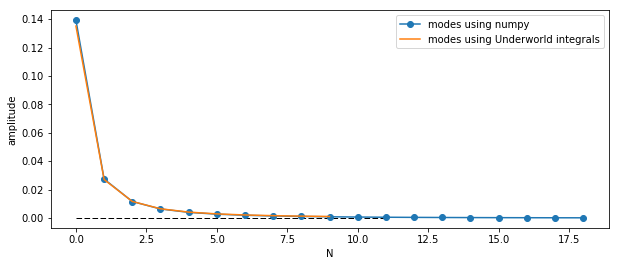

In [126]:

N = arrayData.shape[0]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(-1.*np.real_if_close(fftSum)[1:20]/N, marker = 'o', label = 'modes using numpy'  )
ax.plot(-1.*oscill*np.array(cc[:]), label = 'modes using Underworld integrals' )

ax.hlines(0,0, n, linestyles='--', lw=1. )


ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('amplitude')